<a href="https://colab.research.google.com/github/Sagar401/Natural_Language_Processing/blob/master/Second_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team: Sagar Daswani and Pimchanok Khaoputhai**
# **FAI - Foundations of AI**

# Final Project
## First report

#**Real or Not? Binary Classification of Disaster Tweets**
Kaggle Competition

### **Load Libraries**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
import re
import string
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

## **Data Loading**

In [0]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
#Looking at first few rows of dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **Data Visualization**

### **Basic Exploration**

In [4]:
print("Training Dataset Size:",train_df.shape)
print("Test Dataset Size:",test_df.shape)

Training Dataset Size: (7613, 5)
Test Dataset Size: (3263, 4)


In [0]:
#function to plot bar graph
def plot_bar(x):
  sns.barplot(x.index,x)
  plt.gca().set_ylabel('samples')

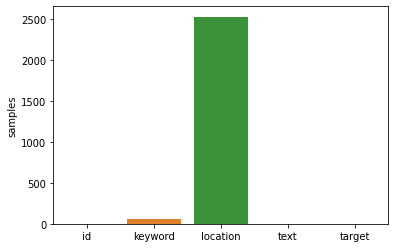

In [13]:
#missing values in training dataset
x = train_df.isnull().sum()
plot_bar(x)

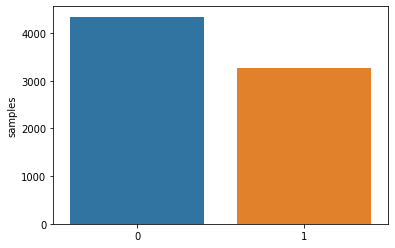

In [14]:
##let's check the class distribution
x = train_df['target'].value_counts()
plot_bar(x)

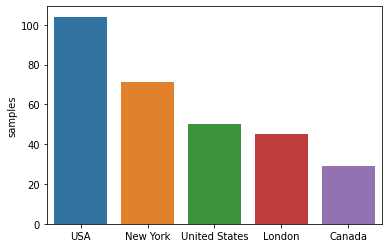

In [18]:
#exlporing top 5 locations 
x = train_df['location'].value_counts()[:5]
plot_bar(x)

### **Hashtag Analysis**
Let's see the impact of Hashtags on tweet sentiments

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non Disaster tweets
Not_Disaster = hashtag_extract(train_df['text'][train_df['target'] == 0])

# extracting hashtags from Disaster tweets
Disaster = hashtag_extract(train_df['text'][train_df['target'] == 1])

# unnesting list
Not_Disaster = sum(Not_Disaster,[])
Disaster = sum(Disaster,[])

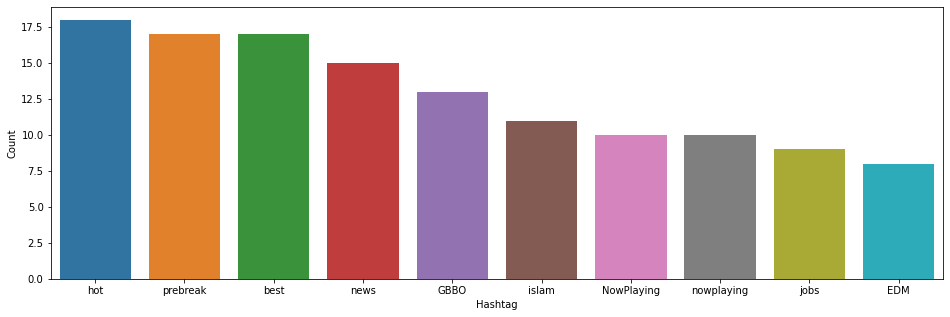

In [31]:
# Fake Disaster tweets
 a = nltk.FreqDist(Not_Disaster)
nd = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
nd = nd.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=nd, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

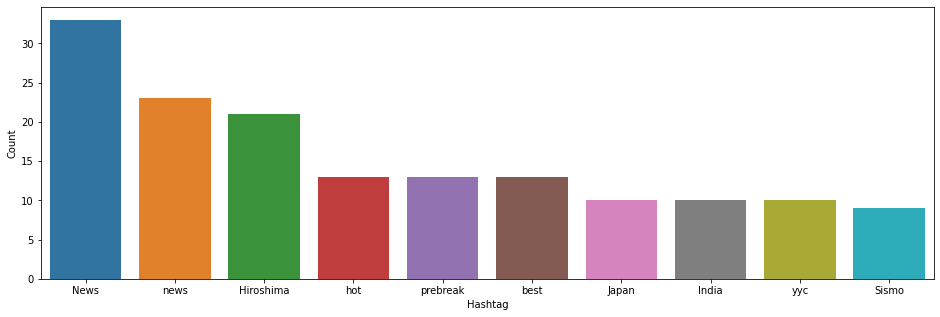

In [33]:
# True Disaster tweets
b = nltk.FreqDist(Disaster)
d = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

##**Data Cleaning and Processing**


*   Making all uppercase to lowercase
*   Removing noise from tweets

  *   URLs
  *   HTML tags
  *   emogis
  *   Punctuation
  *   New-Line
  *   Removing Digits
*   Spell-checker(optional)


In [0]:
#function to remove noise from text
def clean_text(text):
    text = text.lower() #convert to lowercase to maintain standard flow between text
    text = re.sub('\[.*?\]', '', text) #removing text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #removing url
    text = re.sub('<.*?>+', '', text) #removing html tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #removing puntuations
    text = re.sub('\n', '', text)#removing new line from the text field
    text = re.sub('\w*\d\w*', '', text) #removing digits from the string
    return text

train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
#function to remove emoji's
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df['text']=train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_emoji(x))

In [0]:
#run code to install spell checker package
!pip install pyspellchecker

In [0]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

train_df['text']=train_df['text'].apply(lambda x: correct_spellings(x))
test_df['text']=test_df['text'].apply(lambda x: correct_spellings(x))
        

In [0]:
#adding new column with the count of words in a single row
train_df['word_count'] = train_df['text'].str.split().map(len)

#only using the rows with word count more than 0
train_df = train_df[train_df['word_count'] > 0]

#moving forward with 2 column from dataset , i.e., text and target
train_df = train_df[["text","target"]]
test_df = test_df[["text"]]

## **Data Modeling**

### **RNN - From Scratch**

word embedding based on training data

**Neural Network - Deep Learning**

Why not a standard network fit for this data challenge?


*   Inputs, outputs can be of different lengths in different examples
*   Doesn't share features learned across different position of text

To overcome this we use Recurrent Neural Network, 

as it scans words from left to right, one drawback is that it only knows features from its left



**Word Level - Vanilla RNN (RNN from Scratch) (Recurrent Neural Network)**

The idea is to create a word level RNN in python/numpy that will provide a baseline model for more complex Neural Networks architecture, and also to gain low level understanding of the working of RNN (Sequence model)

Credits: 

Andrej Karpathy https://gist.github.com/karpathy/d4dee566867f8291f086: Minimal character-level language model with a Vanilla Recurrent Neural Network, in Python/numpy. And the blog http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

The deep learning book by Michael Nielsen particularly http://neuralnetworksanddeeplearning.com/chap6.html

Andrew ng Deep learning course (Course 5) on Coursera

**Steps Taken:**



1.   Creating a vocabulary list of unique words from data to be later used in encoding each words into a one-hot vector using 1-k encoding. (k = len(vocab_list)
2.   Initialize the RNN model parameters
3.   Feedforward the training data(tweets) vectorized form into the network and calculate loss for that training example
4.   Backpropagate through time and obtain the gradient parameters.
5.   Gradient clipping to avoid exploding gradient problem
6.   Select/iterating over different learning rate and calculating new model paramters
7.   Repeating steps from 3-6 for some number of iterations that covers all training examples atleast 3 times



In [38]:
#creating vocabulary list which will have uniqe word list from training data
vocab_list = list(train_df['text'].str.split(' ',expand=True).stack().unique())
total_words = list(train_df['text'].str.split(' ',expand=True).stack())

vocab_list_size = len(vocab_list)
total_words_len = len(total_words)

print("Vocab size : ",vocab_list_size)
print("Total words in data : ", total_words_len)

#creating a dictionary that has an index for each of the unique words
words_idx = { word:i for i, word in enumerate(vocab_list) }


Vocab size :  16834
Total words in data :  113521


In [0]:
#converting a single training sample to retreive from dictionary
temp = train_df['text'].str.split().values[1]
inputs = [words_idx[i] for i in temp]
output = train_df['target'].values[1]
print("original text:",temp)
print("Wordlist index:",inputs)
print("Target label:",output)

original text: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
Wordlist index: [13, 14, 15, 16, 17, 18, 19]
Target label: 1


In [0]:
#hyperparameters
learning_rate = 0.005
n_a = hidden_size = 100
n_x = vocab_list_size 
n_y = 2

#model_parameters
Waa = np.random.randn(hidden_size,hidden_size)*0.1
Wax = np.random.randn(hidden_size,vocab_list_size)*0.1
Wya = np.random.randn(2,hidden_size)*0.1
ba = np.zeros((n_a,1))
by = np.zeros((n_y,1))

#spliting into training and validation
temp_df = train_df
train_df = train_df.iloc[:7000]
validation_df = temp_df.iloc[7000:]

print('The training set examples: %d' %(len(train_df)))
print('The validation set examples: %d' %(len(validation_df)))


The training set examples: 7000
The validation set examples: 612


In [0]:
#activation function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


In [0]:
#feed-forward -- takes in the index of words in a example tweet and return the prediction
def rnn_feedforward(input_data):
  #initializing
  xt,at = [], np.zeros((n_a,1))
  for t in range(len(input_data)):
    xt.append(np.zeros((n_x,1)))#encode in 1-k one hot-representation
    xt[t][input_data[t]] = 1
    at = np.tanh(np.dot(Waa,at)+np.dot(Wax,xt[t])+ba) #hidden state activation function
    
  yt = np.dot(Wya,at) + by 
  pred = softmax(yt) #softmax function for getting probability for binary classification
  prediction = np.argmax(pred)
  return prediction
  

In [0]:

num_iterations = 5

#memory variables for Adagrad
mWaa, mWya, mWax = np.zeros_like(Waa), np.zeros_like(Wya), np.zeros_like(Wax)
mby, mba = np.zeros_like(by), np.zeros_like(ba)

for i in range(num_iterations):
  
  idx = i%len(train_df)
  example = train_df['text'].str.split().values[idx]
  inputs = [words_idx[i] for i in example]
  print(inputs)
  targets = int(train_df['target'].values[idx])
  
  prediction = rnn_feedforward(inputs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[13, 14, 15, 16, 17, 18, 19]
[12, 20, 21, 22, 23, 24, 25, 2, 26, 27, 28, 29, 30, 31, 32, 33, 23, 24, 25, 34, 2, 35]
[37, 38, 39, 32, 34, 24, 40]
[41, 42, 43, 6, 44, 45, 46, 47, 48, 49, 45, 39, 50, 51, 52, 53]


Function that takes input as one row with text and target value, feedforward the network, calculates the cost which is loss of predicted vs actual Y/target.

Then performs backpropagation and updates the gradient of all the parameters and returns it.

In [0]:
#feedforward and backpropagation
def rnn_model(input_data,targets):
  
  xt,at = [],[]
  at.append(np.zeros((n_a,1)))
  loss = 0
  
  #feed forward
  for t in range(len(input_data)):
    xt.append(np.zeros((n_x,1)))
    xt[t][input_data[t]] = 1
    
    at.append(np.tanh(np.dot(Waa,at[t])+np.dot(Wax,xt[t])+ba))
    
  yt = np.dot(Wya,at[-1]) + by
  pred = np.exp(yt) / np.sum(np.exp(yt),axis=0)
  
  prediction = np.argmax(pred)
  
  #loss-cost
  
  y = np.zeros((2,1))
  y[targets] = 1
  loss = -np.log(np.sum(pred*y,axis = 0)) #cross-entropy loss
  
  #backpropagation through time
  dWaa, dWya, dWax = np.zeros_like(Waa), np.zeros_like(Wya), np.zeros_like(Wax)
  dby, dba = np.zeros_like(by), np.zeros_like(ba)
  
  dy = pred - y
  dWya = np.dot(dy,at[-1].transpose())
  dby = np.copy(dy)
  
  dat = np.dot(Wya.transpose(),dy)
  dtanh = (1-at[-1]*at[-1]) * dat
  
  dWax = np.dot(dtanh, xt[-1].transpose())
  dWaa = np.dot(dtanh, at[-2].transpose())
  dba = np.copy(dtanh)
  da_next = np.dot(Waa.transpose(),dtanh)
  for t in reversed(range(len(input_data)-2)):
    
    dat = np.copy(da_next)
    dtanh = (1- at[t+1] * at[t+1]) * dat
    
    dWax += np.dot(dtanh, xt[t].transpose())
    dWaa += np.dot(dtanh, at[t].transpose())
    dba += np.copy(dtanh)
    da_next = np.dot(Waa.transpose(),dtanh)
    
  for dparams in [dWaa,dWax,dba,dby,dWya]:
    np.clip(dparams,-5,5,out=dparams)
    
  return loss, dWaa, dWax, dba, dby, dWya

 

Feeding training data into the network to retrieve the gradient and using Adagrad optimizer to perform the gradient descent. 

And we repeat this process for all the training examples and for n epochs

**Adagrad Optimizer** : Adaptively scales the learning rate with respect to the accumulated square gradient at each iteration in each dimention

In [0]:

#select any number of iteration for start
num_iterations = 21000

#memory variables for Adagrad optimizer - backprop
mWaa, mWya, mWax = np.zeros_like(Waa), np.zeros_like(Wya), np.zeros_like(Wax)
mby, mba = np.zeros_like(by), np.zeros_like(ba)

for i in range(num_iterations):
  idx = i%len(train_df)
  example = train_df['text'].str.split().values[idx]
  inputs = [words_idx[i] for i in example]
  targets = int(train_df['target'].values[idx])
  
  #prediction = rnn_feedforward(inputs,targets)
  loss,dWaa, dWax, dba, dby, dWya = rnn_model(inputs,targets)
  
  #Adagrad optimizer
  #performing paramete update with Adagrad
  for param, dparam, mem in zip([Waa, Wax, Wya, ba, by],
                                [dWaa, dWax, dWya, dba, dby],
                                [mWaa, mWax, mWya, mba, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem+1e-8) #adagrad update
  
  # validation accuracy
  # using for loop instead of vectorization
  if i % 700 == 0:
    predictions = []
    count=0
    actual_targets= validation_df['target'].tolist()
    for j in range(len(validation_df)):
        example = validation_df['text'].str.split().values[j]
        inputs = [words_idx[l] for l in example]
        predictions.append(rnn_feedforward(inputs))
          
    for y, y_hat in zip(actual_targets, predictions):
        if y==y_hat:
            count+=1
    print('The validation_accuracy after iterations:%d is %d'%(i,(count/len(validation_df))*100))
    

The validation_accuracy after iterations:0 is 47
The validation_accuracy after iterations:700 is 48
The validation_accuracy after iterations:1400 is 51
The validation_accuracy after iterations:2100 is 52
The validation_accuracy after iterations:2800 is 52
The validation_accuracy after iterations:3500 is 55
The validation_accuracy after iterations:4200 is 64
The validation_accuracy after iterations:4900 is 64
The validation_accuracy after iterations:5600 is 70
The validation_accuracy after iterations:6300 is 64
The validation_accuracy after iterations:7000 is 67
The validation_accuracy after iterations:7700 is 66
The validation_accuracy after iterations:8400 is 68
The validation_accuracy after iterations:9100 is 68
The validation_accuracy after iterations:9800 is 72
The validation_accuracy after iterations:10500 is 72
The validation_accuracy after iterations:11200 is 73
The validation_accuracy after iterations:11900 is 69
The validation_accuracy after iterations:12600 is 74
The validati

**Results Summary:**
The validation accuracy arrives closely to 76% (better than randomly guessing). Tried 2 sets of learning rate values with 0.001 accuracy was 70% whereas with learning rate 0.005 accuracy boosted to 76%. 

I have not experimented with other hyperparameters or tried any high level/complex data cleaning. Still, it seems that my RNN is learning association between words that helps to classify the tweets.

Future scope:
we can try different network architectures 
training model for longer iterations

In [0]:
#saving matrix values for parameters which includes weights and biases for later use to predict test data
# saving the model
import pickle
filename = 'rnn_model_v1.pkl'
with open(filename, "wb") as f:
    pickle.dump((Waa, Wax, ba, by, Wya ), f)

In [0]:
#loading the saved model
import pickle
filename = 'rnn_model_v1.pkl'
with open(filename, "rb") as f:
    Waa, Wax, ba, by, Wya  = pickle.load(f)

In [0]:
#checking if parameters loaded in correctly
#using loaded model
count = 0
for j in range(len(validation_df)):
  
  example = validation_df['text'].str.split().values[j]
  inputs = [words_idx[l] for l in example]
  predictions.append(rnn_feedforward(inputs))
          
for y, y_hat in zip(actual_targets, predictions):
  if y==y_hat:
    count+=1
print("Correctly Predicted:",count)
print("Total Data in validation set:",len(validation_df))
print('The validation_accuracy is',(count/len(validation_df))*100)

Correctly Predicted: 434
Total Data in validation set: 612
The validation_accuracy is 70.91503267973856


### **RNN - Tensorflow/Keras** (Part - 1)

Word Embedding based on training data

In [0]:
training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]
                  
training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]


In [0]:
tokenizer = Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [0]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding='post')


In [0]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [0]:
model_embed = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index), 32),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_embed.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_26 (Dense)             (None, 50)                12850     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 982,117
Trainable params: 982,117
Non-trainable params: 0
_______________________________________________

In [0]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 - 30s - loss: 0.6809 - accuracy: 0.5805 - val_loss: 0.6903 - val_accuracy: 0.5323
Epoch 2/20
6000/6000 - 24s - loss: 0.5449 - accuracy: 0.6922 - val_loss: 0.5028 - val_accuracy: 0.7407
Epoch 3/20
6000/6000 - 24s - loss: 0.3697 - accuracy: 0.8460 - val_loss: 0.5089 - val_accuracy: 0.7568
Epoch 4/20
6000/6000 - 24s - loss: 0.2956 - accuracy: 0.8842 - val_loss: 0.5019 - val_accuracy: 0.7661
Epoch 5/20
6000/6000 - 24s - loss: 0.2360 - accuracy: 0.9137 - val_loss: 0.5775 - val_accuracy: 0.7215
Epoch 6/20
6000/6000 - 24s - loss: 0.1876 - accuracy: 0.9288 - val_loss: 0.6298 - val_accuracy: 0.7426
Epoch 7/20
6000/6000 - 24s - loss: 0.1529 - accuracy: 0.9468 - val_loss: 0.7191 - val_accuracy: 0.7301
Epoch 8/20
6000/6000 - 24s - loss: 0.1298 - accuracy: 0.9550 - val_loss: 0.7412 - val_accuracy: 0.7196
Epoch 9/20
6000/6000 - 24s - loss: 0.1189 - accuracy: 0.9575 - val_loss: 0.7660 - val_accuracy: 0.7233
Epoch 10/20
6000/6000 - 2

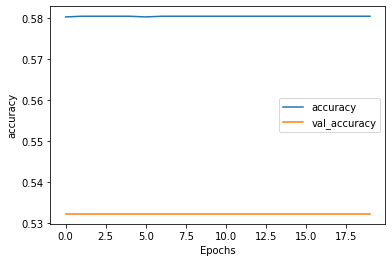

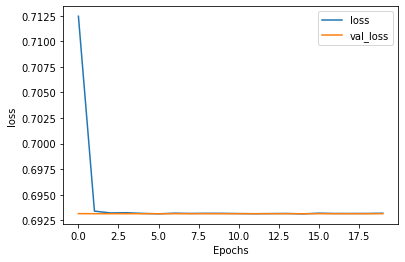

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(train_df.target[2])

our deeds are the reason of this earthquake may allah forgive us all ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
1


In [0]:
sentence = ["granny starting to fear spiders in the garden might be real", "coronavirus is spreading in my neighborhood","Coronavirus is love"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding='post')
print(model.predict(padded))

[[0.0068009 ]
 [0.67498094]
 [0.02055607]]


### **RNN - Tensorflow/Keras** (Part - 2)

GloVe for Embedding - Global vectors for word representation. It is a unsupervised learning algorithm developed by standford for generating word embedding by aggregating global word-word co-occurance matrix

In [0]:
train_complete = [ i for i in train_df.text]

training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]
                  
training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]

In [0]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_complete)

training_sequences=tokenizer_obj.texts_to_sequences(training_sentences)
training_padded=pad_sequences(training_sequences,maxlen=MAX_LEN,truncating='post',padding='post')

test_sequences=tokenizer_obj.texts_to_sequences(test_sentences)
test_padded=pad_sequences(test_sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [0]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 16833


In [0]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16833/16833 [00:00<00:00, 492214.25it/s]


In [0]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [0]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1683400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,725,705
Trainable params: 42,305
Non-trainable params: 1,683,400
_________________________________________________________________


In [0]:
history=model.fit(training_padded,training_labels,batch_size=4,epochs=15,validation_data=(test_padded,test_labels),verbose=2)




Train on 6000 samples, validate on 1612 samples
Epoch 1/15





 - 55s - loss: 0.6910 - acc: 0.5795 - val_loss: 0.6913 - val_acc: 0.5323
Epoch 2/15
 - 52s - loss: 0.6821 - acc: 0.5805 - val_loss: 0.6828 - val_acc: 0.5323
Epoch 3/15
 - 50s - loss: 0.6636 - acc: 0.5808 - val_loss: 0.6508 - val_acc: 0.5323
Epoch 4/15
 - 50s - loss: 0.6329 - acc: 0.6247 - val_loss: 0.6019 - val_acc: 0.7301
Epoch 5/15
 - 50s - loss: 0.6079 - acc: 0.7028 - val_loss: 0.5713 - val_acc: 0.7730
Epoch 6/15
 - 51s - loss: 0.5897 - acc: 0.7190 - val_loss: 0.5549 - val_acc: 0.7754
Epoch 7/15
 - 52s - loss: 0.5785 - acc: 0.7255 - val_loss: 0.5418 - val_acc: 0.7785
Epoch 8/15
 - 52s - loss: 0.5750 - acc: 0.7357 - val_loss: 0.5281 - val_acc: 0.7767
Epoch 9/15
 - 53s - loss: 0.5712 - acc: 0.7343 - val_loss: 0.5215 - val_acc: 0.7748
Epoch 10/15
 - 53s - loss: 0.5654 - acc: 0.7448 - val_loss: 0.5156 - val_acc: 0.7866
Epoch 11/15
 - 53s - loss: 0.5665 - acc: 0.7317 - val_loss: 0.5121 - val_acc: 0.7847
Epoch 12/15
 - 52s

In [0]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")